In [1]:
from matplotlib import pyplot as plt
from matplotlib import animation

import networkx as nx
import numpy as np
import numpy.ma as ma
import pandas as pd

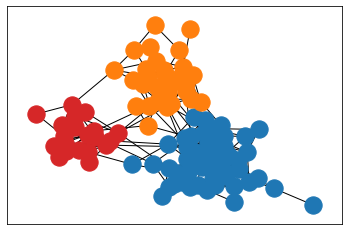

In [2]:
sizes = [20, 50, 30]
probs = [[0.25,0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 1/6]]
G = nx.stochastic_block_model(sizes, probs, seed=30)
A = nx.convert_matrix.to_numpy_matrix(G)

pos = nx.spring_layout(G, seed=3113794652)
nx.draw_networkx_nodes(G, pos, nodelist=range(0,sizes[0]), node_color="tab:red")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0], sizes[0]+sizes[1]), node_color="tab:blue")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0]+sizes[1], 100), node_color="tab:orange")
nx.draw_networkx_edges(G, pos)

In [232]:
pd.DataFrame(A, dtype=int).to_csv("EF2 Notebook SBM 1")

# Run baseline strategy

1. Go if any of your friends went and it wasn't too crowded last time
2. Otherwise go with small random probability

In [15]:
def plot_mask(t, friends, mask, color):
    x = np.take(t, np.where(mask))
    y = np.take(friends, np.where(mask))
    plt.scatter(x=x, y=y,color=color)
    

def summarize_run(Xs):
    Xnp = np.hstack(Xs)
    attendance = np.ravel(Xnp.sum(axis=0))
    
    plt.figure()
    plt.plot(attendance)
    plt.plot([0, n_iter], [M, M], "--")
    plt.title("Attendance by week")
    
    plt.figure()

    too_full = attendance > 60

    # col j has the number of friends of each node
    # that attended on week j
    # mask agents that did not attend
    fma = ma.masked_array(A.dot(Xnp), 1-Xnp)
    # mean friend count per week
    friends = np.ravel(fma.mean(axis=0).data)
    too_full = Xnp.sum(axis=0) > 60

    t = range(len(friends))
    plot_mask(t, friends, too_full, "r")
    plot_mask(t, friends, [~c for c in too_full], "g")
    plt.title("Average friend count of attendees")

In [21]:
rng = np.random.default_rng()

# random initial conditions
X = rng.uniform(size=(100,1)) < 0.3
Xs = [X]
eps = 0.03 # small random probability for cold start
M = 60 # maximum capacity before it's too crowded
n_iter = 100

for _ in range(n_iter):
    if X.sum() < M:
        X  = X + (A.dot(X) > 0)
    else:
        X = np.zeros(shape=(100,1))

    X += rng.uniform(size=(100,1)) < eps
    Xs.append(X)

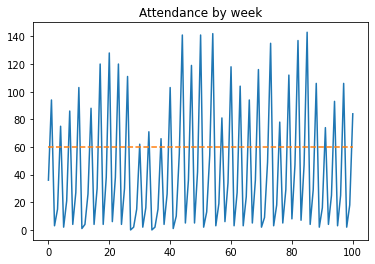

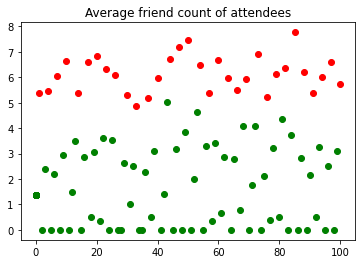

In [22]:
summarize_run(Xs)

This strategy will just keep spreading until blows up, and then start again with a small random group.  What happens if you only go back if at least 2 friends were there?

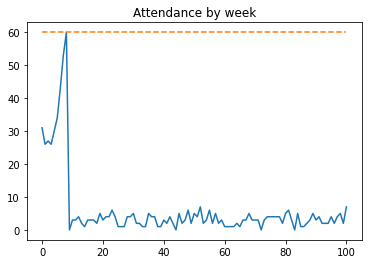

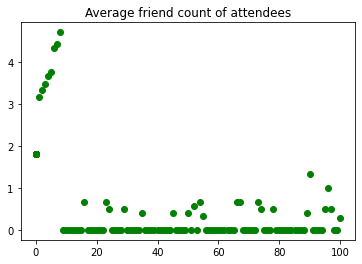

In [27]:
# random initial conditions
X = rng.uniform(size=(100,1)) < 0.3
Xs = [X]
eps = 0.03 # small random probability for cold start
M = 60 # maximum capacity before it's too crowded
n_iter = 100

# how many friends do you need to be there to go back
minfriends = 2

for _ in range(n_iter):
    if X.sum() < M:
        # go if enough of your friends went last week
        # whether or not you went
        X = (A.dot(X) > minfriends)
    else:
        X = np.zeros(shape=(100,1))

    X += rng.uniform(size=(100,1)) < eps
    Xs.append(X)
    
summarize_run(Xs)

Okay so now nobody goes because they don't have enough of their friends going to get a group together.  I think there must be some triangles that would have some sort of unstable equilibrium?

What if we start with one of the communities as an initial condition?

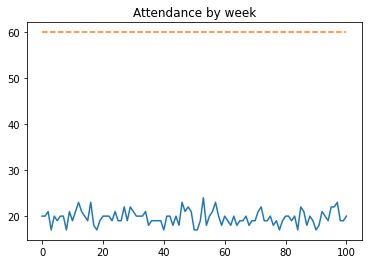

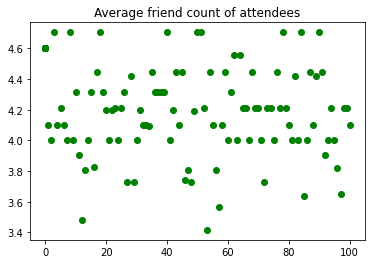

In [36]:
X = np.zeros((100,1))
X[:sizes[0]] = 1

Xs = [X]
eps = 0.03 # small random probability for cold start
M = 60 # maximum capacity before it's too crowded
n_iter = 100

# how many friends do you need to be there to go back
minfriends = 2

for _ in range(n_iter):
    if X.sum() < M:
        # go if enough of your friends went last week
        # whether or not you went
        X = (A.dot(X) > minfriends)
    else:
        X = np.zeros(shape=(100,1))

    X += rng.uniform(size=(100,1)) < eps
    Xs.append(X)
    
summarize_run(Xs)

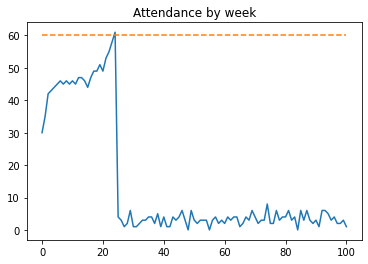

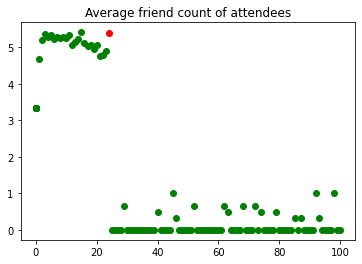

In [40]:
X = np.zeros((100,1))
X[sizes[0]:sizes[1]] = 1

Xs = [X]
eps = 0.03 # small random probability for cold start
M = 60 # maximum capacity before it's too crowded
n_iter = 100

# how many friends do you need to be there to go back
minfriends = 2

for _ in range(n_iter):
    if X.sum() < M:
        # go if enough of your friends went last week
        # whether or not you went
        X = (A.dot(X) > minfriends)
    else:
        X = np.zeros(shape=(100,1))

    X += rng.uniform(size=(100,1)) < eps
    Xs.append(X)
    
summarize_run(Xs)

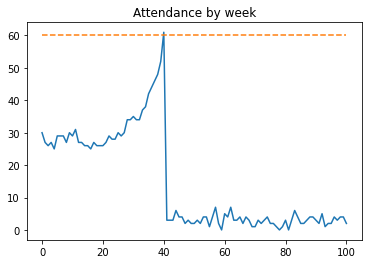

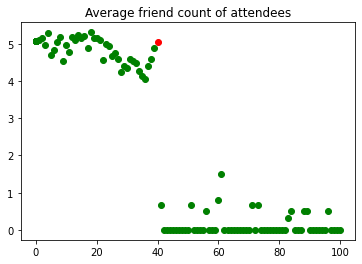

In [41]:
X = np.zeros((100,1))
X[sizes[0] + sizes[1]:] = 1

Xs = [X]
eps = 0.03 # small random probability for cold start
M = 60 # maximum capacity before it's too crowded
n_iter = 100

# how many friends do you need to be there to go back
minfriends = 2

for _ in range(n_iter):
    if X.sum() < M:
        # go if enough of your friends went last week
        # whether or not you went
        X = (A.dot(X) > minfriends)
    else:
        X = np.zeros(shape=(100,1))

    X += rng.uniform(size=(100,1)) < eps
    Xs.append(X)
    
summarize_run(Xs)

Okay so there are two issues here with stability.  One is that it's hard to get the seed of critical mass to start a repeat group going.  The other is that once it gets over capacity the whole thing is completely destroyed.  Just out of curiosity, before addressing either of those, will a critical mass eventually emerge if we run it for much longer?

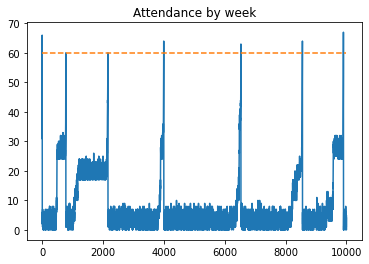

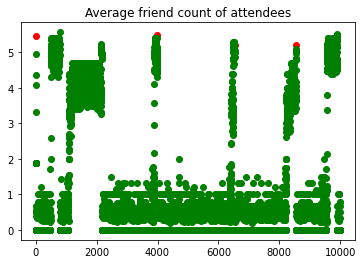

In [42]:
X = rng.uniform(size=(100,1)) < 0.3

Xs = [X]
eps = 0.03 # small random probability for cold start
M = 60 # maximum capacity before it's too crowded
n_iter = 10000

# how many friends do you need to be there to go back
minfriends = 2

for _ in range(n_iter):
    if X.sum() < M:
        # go if enough of your friends went last week
        # whether or not you went
        X = (A.dot(X) > minfriends)
    else:
        X = np.zeros(shape=(100,1))

    X += rng.uniform(size=(100,1)) < eps
    Xs.append(X)
    
summarize_run(Xs)

Yes!  It will emerge it just blows up really fast when it happens.  How can we make this less explode-y?  We could use memory, or set a higher bar for friends?  Hmmmmmmm

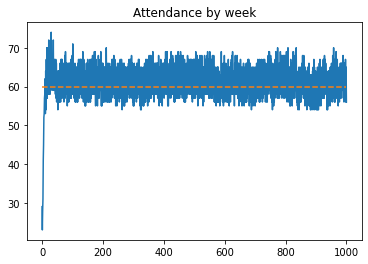

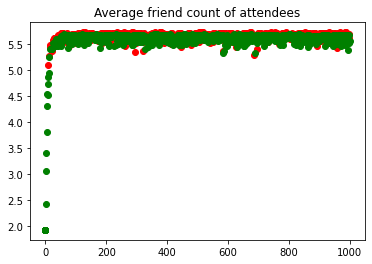

In [44]:
X = rng.uniform(size=(100,1)) < 0.3

Xs = [X]
eps = 0.03 # small random probability for cold start
M = 60 # maximum capacity before it's too crowded
n_iter = 1000

# how many friends do you need to be there to go back
minfriends = 2

# how many friends do you need to be there to go back
# even though it was too crowded
minbad = 3

for _ in range(n_iter):
    if X.sum() < M:
        # go if enough of your friends went last week
        # whether or not you went
        X = (A.dot(X) > minfriends)
    else:
        X = (A.dot(X) > minbad)

    X += rng.uniform(size=(100,1)) < eps
    Xs.append(X)
    
summarize_run(Xs)

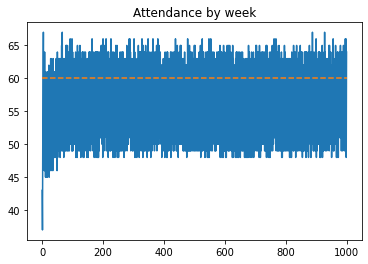

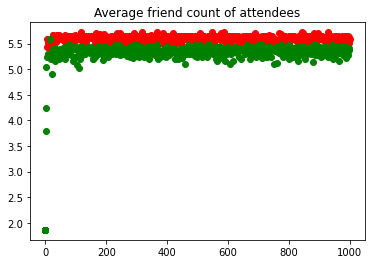

In [45]:
X = rng.uniform(size=(100,1)) < 0.3

Xs = [X]
eps = 0.03 # small random probability for cold start
M = 60 # maximum capacity before it's too crowded
n_iter = 1000

# how many friends do you need to be there to go back
minfriends = 2

# how many friends do you need to be there to go back
# even though it was too crowded
minbad = 4

for _ in range(n_iter):
    if X.sum() < M:
        # go if enough of your friends went last week
        # whether or not you went
        X = (A.dot(X) > minfriends)
    else:
        X = (A.dot(X) > minbad)

    X += rng.uniform(size=(100,1)) < eps
    Xs.append(X)
    
summarize_run(Xs)

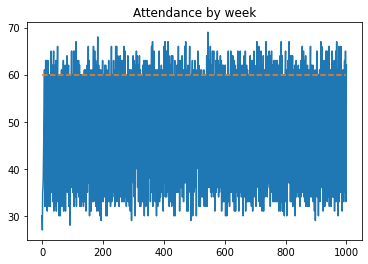

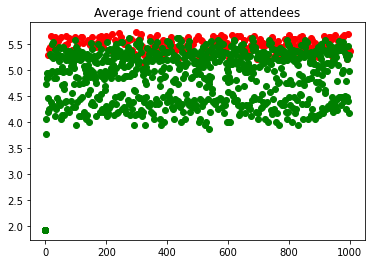

In [46]:
X = rng.uniform(size=(100,1)) < 0.3

Xs = [X]
eps = 0.03 # small random probability for cold start
M = 60 # maximum capacity before it's too crowded
n_iter = 1000

# how many friends do you need to be there to go back
minfriends = 2

# how many friends do you need to be there to go back
# even though it was too crowded
minbad = 5

for _ in range(n_iter):
    if X.sum() < M:
        # go if enough of your friends went last week
        # whether or not you went
        X = (A.dot(X) > minfriends)
    else:
        X = (A.dot(X) > minbad)

    X += rng.uniform(size=(100,1)) < eps
    Xs.append(X)
    
summarize_run(Xs)

In [145]:
# track the boundaries between communities
# instead of the size
transitions = np.array(sizes)

for i in range(len(transitions)-1):
    transitions[i + 1] = transitions[i + 1] + transitions[i]

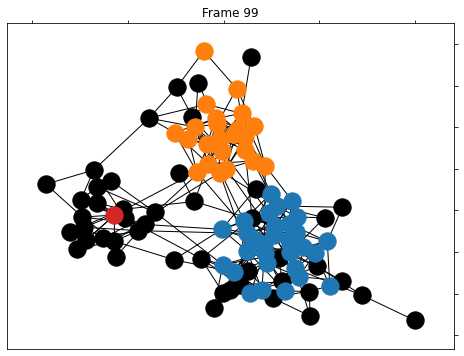

In [116]:
def animate_step(t, pos, G, ax):
    ax.clear()
    Xnp = np.hstack(Xs)

    went = np.where([Xnp[:,t]])[1]
    home = np.where([1 - Xnp[:,t]])[1]

    nx.draw_networkx_nodes(G, pos, nodelist=home, node_color="black")

    colors = ["tab:red", "tab:blue", "tab:orange"]

    for i, c in enumerate(colors):
        # which members of group i went?
        mask = went < transitions[i]

        if i > 0:
            mask = np.logical_and(mask, went > transitions[i-1])

        nx.draw_networkx_nodes(G, pos, nodelist=went[np.where(mask)], node_color=c)

    nx.draw_networkx_edges(G, pos)

    # Set the title
    ax.set_title("Frame {}".format(t))
    
    
def make_animation(Xs, title):
    fig, ax = plt.subplots(figsize=(8,6))
    ani = animation.FuncAnimation(fig, animate_step, frames=Xnp.shape[1], fargs=(pos, G, ax))
    ani.save(title, writer="pillow")
    
    
make_animation(Xs, "../images/strategy_0.gif")

Questions:
    
Who is going always vs. sometimes vs. never?
Does the outcome vary based on initial conditions?

In [129]:
Xnp = np.hstack(Xs)

ppl, times = np.where(Xnp)

<AxesSubplot:ylabel='Frequency'>

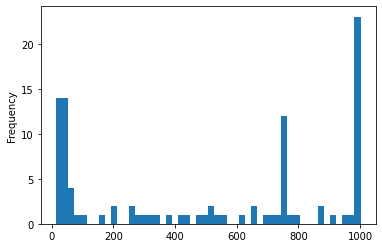

In [141]:
pd.Series(ppl).value_counts().plot(kind='hist',bins=50)

Welp...  There are some always and some nevers and some sometimeses.  Not really sure what to say about this...

Let's run this a few more times and see how similar it is.  What would I like to compare between rounds?  I am curious if the always/sometimes/never nodes are stable. 

In [150]:
def run_sim(n_iter, X, eps, M, minfriends, minbad):
    Xs = [X]
    for _ in range(n_iter):
        if X.sum() < M:
            # go if enough of your friends went last week
            # whether or not you went
            X = (A.dot(X) > minfriends)
        else:
            X = (A.dot(X) > minbad)

        X += rng.uniform(size=(100,1)) < eps
        Xs.append(X)
    return np.hstack(Xs)

In [151]:
eps = 0.03 # small random probability for cold start
M = 60 # maximum capacity before it's too crowded
n_iter = 1000

# how many friends do you need to be there to go back
minfriends = 2

# how many friends do you need to be there to go back
# even though it was too crowded
minbad = 5

Xnps = []

for i in range(30):
    X = rng.uniform(size=(100,1)) < 0.3
    Xnps.append(
        run_sim(n_iter, X, eps, M, minfriends, minbad))
    print(f"Ran simulation {i}")


Ran simulation 0
Ran simulation 1
Ran simulation 2
Ran simulation 3
Ran simulation 4
Ran simulation 5
Ran simulation 6
Ran simulation 7
Ran simulation 8
Ran simulation 9
Ran simulation 10
Ran simulation 11
Ran simulation 12
Ran simulation 13
Ran simulation 14
Ran simulation 15
Ran simulation 16
Ran simulation 17
Ran simulation 18
Ran simulation 19
Ran simulation 20
Ran simulation 21
Ran simulation 22
Ran simulation 23
Ran simulation 24
Ran simulation 25
Ran simulation 26
Ran simulation 27
Ran simulation 28
Ran simulation 29


In [172]:
# skip first 50 rounds to give time to settle
attendance = [np.where(Xnp[:,50:]) for Xnp in Xnps]
ppl = [pd.Series(a[0]) for a in attendance]
ppl[1].shape

(47646,)

In [185]:
cnts = pd.DataFrame(ppl[0].value_counts(), columns=[0])
for i in range(1,30):
    cnts[i] = ppl[i].value_counts()
    
cnts.mean(axis=1)

24    810.200000
72    813.666667
89    811.833333
26    809.900000
90    813.166667
         ...    
59     26.600000
1      73.333333
9      29.233333
13     76.666667
15     73.900000
Length: 100, dtype: float64

In [187]:
cnts.loc[24].describe()

count     30.000000
mean     810.200000
std      326.002369
min       26.000000
25%      951.000000
50%      951.000000
75%      951.000000
max      951.000000
Name: 24, dtype: float64

In [188]:
cnts.loc[72].describe()

count     30.000000
mean     813.666667
std      320.140199
min       31.000000
25%      951.000000
50%      951.000000
75%      951.000000
max      951.000000
Name: 72, dtype: float64

In [203]:
mask = list(np.where(cnts.loc[24] < 900)[0])
cnts[mask]

,9,13,15,16,17
24,31,34,403,38,26
72,37,65,473,31,33
89,33,44,443,29,36
26,27,28,403,26,38
90,36,58,472,27,31
...,...,...,...,...,...
59,30,32,29,27,36
1,27,889,520,32,24
9,28,43,31,19,34
13,26,951,537,30,27


In [206]:
cnts[15].sort_values()

99     23
70     24
52     26
61     26
81     28
     ... 
18    598
10    601
8     602
14    621
19    731
Name: 15, Length: 100, dtype: int64

In [207]:
cnts.max(axis=0)

0     951
1     951
2     951
3     951
4     951
5     951
6     951
7     951
8     951
9      40
10    951
11    951
12    951
13    951
14    951
15    731
16     42
17     51
18    951
19    951
20    951
21    951
22    951
23    951
24    951
25    951
26    951
27    951
28    951
29    951
dtype: int64

<AxesSubplot:>

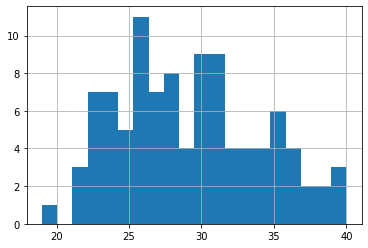

In [212]:
cnts[9].hist(bins=20)

<AxesSubplot:>

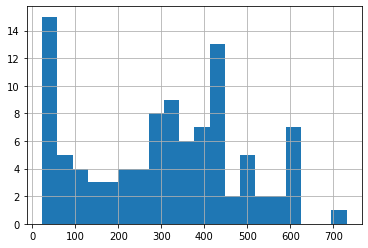

In [213]:
cnts[15].hist(bins=20)

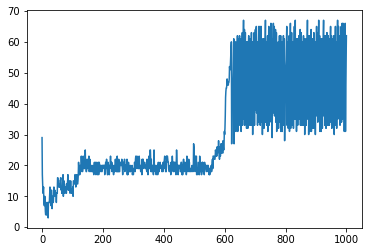

In [223]:
# plt.plot(Xnps[9].sum(axis=0)[-100:])
plt.plot(np.ravel(Xnps[15].sum(axis=0)[-100:]))

This is really interesting...  there can be phase transitions here where a lucky chance shifts the entire system after a long time in a relatively stable configuration.  There can be other times where the whole system seems to settle to almost nobody.  Most of the time the system seems to settle into a solution that is close to capacity and fairly stable.

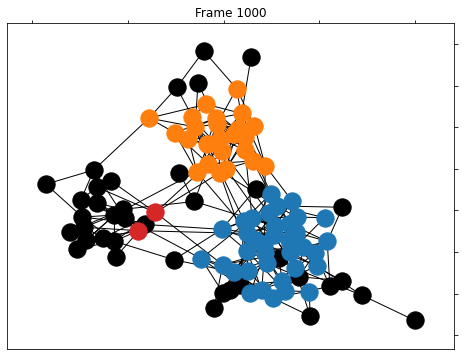

In [227]:
def animate_step(t, Xnp, pos, G, ax):
    ax.clear()

    went = np.where([Xnp[:,t]])[1]
    home = np.where([1 - Xnp[:,t]])[1]

    nx.draw_networkx_nodes(G, pos, nodelist=home, node_color="black")

    colors = ["tab:red", "tab:blue", "tab:orange"]

    for i, c in enumerate(colors):
        # which members of group i went?
        mask = went < transitions[i]

        if i > 0:
            mask = np.logical_and(mask, went > transitions[i-1])

        nx.draw_networkx_nodes(G, pos, nodelist=went[np.where(mask)], node_color=c)

    nx.draw_networkx_edges(G, pos)

    # Set the title
    ax.set_title("Frame {}".format(t))
    
    
def make_animation(Xnp, title):
    fig, ax = plt.subplots(figsize=(8,6))
    ani = animation.FuncAnimation(fig, animate_step, frames=Xnp.shape[1], fargs=(Xnp, pos, G, ax))
    ani.save(title, writer="pillow")
    
    
make_animation(Xnps[15], "../images/strategy_0_trial_15.gif")

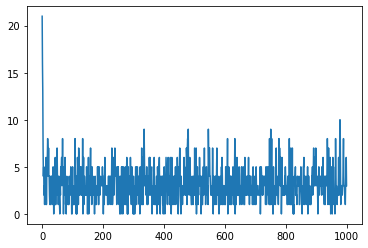

In [224]:
plt.plot(np.ravel(Xnps[9].sum(axis=0)[-100:]))

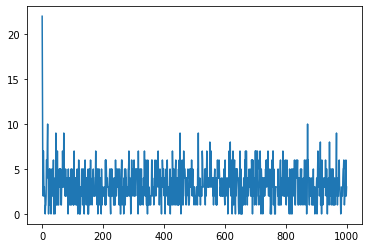

In [225]:
plt.plot(np.ravel(Xnps[17].sum(axis=0)[-100:]))

This will never be totally stable because of the random new people that turn up every week.  Wait what happens without them now?  This is one of those heating up the system things!

In [ ]:
eps = 0.0
M = 60 # maximum capacity before it's too crowded
n_iter = 1000

# how many friends do you need to be there to go back
minfriends = 2

# how many friends do you need to be there to go back
# even though it was too crowded
minbad = 5

Xnps = []

for i in range(30):
    X = rng.uniform(size=(100,1)) < 0.3
    Xnps.append(
        run_sim(n_iter, X, eps, M, minfriends, minbad))
    print(f"Ran simulation {i}")